1. Define Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta, date
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import os
from scipy import linalg
from scipy import stats
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mapping_tickers import *

2a. Define Tickers

In [17]:
crypto_etf_tickers = [
    'IBIT', 'GBTC', 'FBTC', 'ETHE', 'ARKB', 'BITB', 'BITO', 'BITX', 'HODL', 'BRRR',
    'BTCO', 'EZBC', 'BITU', 'BITQ', 'WGMI', 'ETHU', 'FDIG', 'EETH', 'BTCW', 'CRPT',
    'BITI', 'BTF', 'STCE', 'YBTC', 'BTFX', 'EFUT', 'BITS', 'MAXI', 'SBIT', 'ETHT',
    'ARKA', 'AETH', 'DEFI', 'ARKZ', 'BITC', 'ETHA', 'BTOP', 'SATO', 'BETH', 'BETE',
    'BTCL', 'ARKY', 'REKT', 'SETH', 'ZZZ', 'ARKC', 'ETHD', 'FIAT', 'LMBO', 'BTCZ'
]

etf_tickers = {
    'ARKK': 'ARK Innovation ETF',
    'DJIA': 'Global X Dow 30 Covered Call ETF',
    'SPY': 'SPDR S&P 500 ETF Trust',
    'QQQ': 'Invesco QQQ Trust, NASDAQ 100 Index ETF',
    'VOO': 'Vanguard S&P 500 ETF',
    'VTI': 'Vanguard Total Stock Market Index Fund ETF Shares',
    'VWO': 'Vanguard Emerging Markets Stock Index Fund',
    'XLF': 'The Financial Select Sector SPDR Fund',
}

# tickers = list(etf_tickers.keys())
# tickers = crypto_etf_tickers
# tickers = list(stock_index_tickers.keys())
# tickers = list(volatility_tickers.keys())
# tickers = list(yt_example_tickers.keys())
# tickers = list(djia_components.keys())
# tickers = list(ndx_top30_components.keys())
tickers = list(magnificent_7_tickers.keys())
# tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN']  # 5 top by market cap
# tickers = ['AAPL', 'CSCO', 'MSFT', 'MMM', 'IBM', 'VZ', 'INTC']  # IT tickers in G. Pasini's paper
# tickers = ['AXP', 'GE', 'GS', 'JPM', 'TRV']  # FIN tickers in G. Pasini's paper

# Benchmark ticker - will be user's input from dashboard app
tk_market = '^GSPC'  # S&P 500 Index for stocks
# tk_market = 'GBTC'  # Grayscale Bitcoin Trust ETF for cryptos
# tk_market = '^VIX'
print(tickers)

['NVDA', 'AAPL', 'TSLA', 'MSFT', 'AMZN', 'META', 'GOOG']


2b. Define Weights

In [3]:
# By defining weights up front, the user will be able to examine statistical properties
# of the weighted portfolio, not just of individual stocks. Different options for choosing
# weights should be offered, e.g.:
#   - weights all equal
#   - weights based on market cap or a similar metric as long as it's consistent across tickers
#   - weights custom specified
#   - if PCA has already been performed: weights based on the first principal eigenvector

3. Define Start and End Dates

In [4]:
# NOTE: These will be user's inputs from the dashboard app. The user should be provided 
# with the first date the data for a chosen ticker is available, which should help with 
# the selection of both the tickers and the start date.
#
# NOTE: 
# 1) A choice for the end date should also be provided in the app, so the user can test
# portfolio's performance during a selected historical period, e.g. during a financial crisis.
# 2) A custom choice of year, month and day should also be provided for both the start and end date

end_date = datetime.today()
hist_years = 1
hist_months = 0
hist_days = 0
start_date = datetime(end_date.year - hist_years, end_date.month - hist_months, end_date.day - hist_days)

# end_date = datetime(2017, 1, 13)    # recreating PCA results in G. Pasini's article
# start_date = datetime(2000, 3, 17)  # recreating PCA results in G. Pasini's article
print(start_date, end_date)

2023-09-19 00:00:00 2024-09-19 17:16:54.736266


4. Download Adjusted Close Prices and Volumes

In [18]:
# Adjusted Close are more accurate than regular Close because they include dividends and stock splits
df_adj_close = pd.DataFrame()
df_volume = pd.DataFrame()
df_dollar_volume = pd.DataFrame()
for tk in tickers:
    data = yf.download(tk, start=start_date, end=end_date)
    # data = yf.download(tk, period='1d')
    # print(f'{tk}:\t{data.index[0]}\t{data["Adj Close"].values[0]:.8f}\t{data["Volume"].values[0]:.8f}')
    df_adj_close[tk] = data['Adj Close']
    df_volume[tk] = data['Volume']
    df_dollar_volume[tk] = data['Adj Close'] * data['Volume']

# Dropping dates with NaNs now in order to avoid dropping two consecutive dates for each NaN later
# (each log return is based on two consecutive dates, so log returns at both of them would be NaN
# if any of them is NaN)

# Below are checks on when the data starts for any ticker, i.e. when the initial NaNs end.
# E.g. dropping NaNs for etf_tickers shortens the historical period from 3 years to 2.5 years because
# of the missing data for DJIA.

# Check for Adj Close data start. Volume data start together with the prices data,
# so there is no need to check df_volume.

df_adj_close_start = pd.DataFrame(columns=['Adj Close Start Date'])
last_date_tk = df_adj_close.index.max().date()
missing_end_date_tickers = []

for tk in tickers:
    start_date_tk = df_adj_close.index[~df_adj_close[tk].isna()].min().date()
    last_nan_date_tk = df_adj_close.index[df_adj_close[tk].isna()].max().date()
    
    # print(tk, start_date_tk, last_nan_date_tk, end_date.date())

    if (start_date_tk > start_date.date()) & ~pd.isnull(last_nan_date_tk):
        if last_nan_date_tk < start_date_tk:
            df_adj_close_start.loc[tk, 'Adj Close Start Date'] = start_date_tk

    if ~pd.isnull(last_nan_date_tk) & (last_nan_date_tk == end_date.date()):
        missing_end_date_tickers.append(tk)
        
if len(df_adj_close_start) > 0:
    min_start_date_adj_close_tk = df_adj_close_start['Adj Close Start Date'].min()
    print(f'WARNING: Data for these tickers start after the selected start date of {start_date.date()}.')
    for tk in df_adj_close_start.index:
        print(f"\t{tk}:\t{df_adj_close_start.loc[tk, 'Adj Close Start Date']}")
    print(f'The whole portfolio data will be truncated to start at {min_start_date_adj_close_tk}.')
    print(f'Please consider adjusting the start date or removing some tickers if you wish to avoid that.')

if last_date_tk < end_date.date():
    print(f'WARNING: No data available for the selected portfolio tickers at the end date of {end_date.date()}.')
    print(f'The portfolio data will be truncated to end at the latest available date of {last_date_tk}.')
elif len(missing_end_date_tickers) > 0:
    print(f'WARNING: Data for these tickers is missing for the selected end date of {end_date.date()}.')
    print(missing_end_date_tickers)
    print(f'The whole portfolio data will be truncated to end at the latest date containing data for all tickers.')

df_adj_close = df_adj_close.dropna()  
# print(df_adj_close.iloc[-1])
# print(len(df_adj_close))
# display(df_adj_close)

df_volumes = df_volume.dropna()
# print(df_volume.iloc[-1])
# print(len(df_volume))

df_dollar_volume = df_dollar_volume.dropna()
# print(df_dollar_volume.iloc[-1])
# print(len(df_dollar_volume))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


5. Calculate Log Returns and Their Moments

>>NOTE: The downturns or downsides, as used in the Sortino Ratio, should probably be calculated relative to the daily risk-free return rate (Rf). 

>> That is, those should be the downturns/downsides of Rp-Rf rather than Rp. See, for example, https://www.youtube.com/watch?v=zN0JlQ_I52M

In [27]:
x = np.log(df_adj_close / df_adj_close.shift(1))
# x = x[~np.ma.fix_invalid(x).mask.any(axis=1)]  
# The line above removes invalid elements such as NaN or Inf, can be used instead of df.dropna()
x_downturns = np.where(x < 0, x, 0)  # Keep only non-positive returns for Sortino ratio

log_returns = pd.DataFrame(x, columns=tickers, index=df_adj_close.index).dropna()

# display(log_returns)

x_standardized = StandardScaler().fit_transform(x)
log_returns_standardized = pd.DataFrame(x_standardized, columns=tickers, index=df_adj_close.index).dropna()
log_returns_downturns = pd.DataFrame(x_downturns, columns=tickers, index=df_adj_close.index).dropna()


def historical_var(returns_tk, p_level=5):
    """
    returns_tk:         returns for ticker tk
    confidence_level:   percent confidence level
    """
    return returns_tk.quantile(p_level / 100)


def historical_cvar(returns_tk, p_level=5):
    """
    returns_tk:         returns for ticker tk
    confidence_level:   percent confidence level
    """
    in_tail = returns_tk <= historical_var(returns_tk, p_level)
    return returns_tk[in_tail].mean()


# NOTE: 
# 1) Pandas skewness() and kurtosis() are unbiased estimators, i.e. they are corrected for bias (N-1 instead of N).
# 2) Scipy.stats skew() and kurtosis() are BIASED (uncorrected, based on N) by default and provide a bias parameter
#    which can be set to False if an unbiased estimate is required. 
# 3) Scipy.stats.describe() provides BIASED (uncorrected, based on N) estimates for skewness and kurtosis, but
#    an UNBIASED (corrected, based on N-1) estimate for variance.
# 4) Scipy.stats.kurtosis() provides excess (Fisher) kurtosis by default, which can be changed by setting fisher=False.
# 5) Skewness and kurtosis do not have to be annualised as they do not depend on frequency -
#    see e.g. https://www.youtube.com/watch?v=skmYLg7vk3g

stats_metrics = [
    'Observations',
    'Minimum',
    'Maximum',
    'Mean',
    'Median',
    'Standard Deviation',
    'Variance',
    'Annual Volatility',
    'Annual Variance',
    'Skewness',
    'Excess Kurtosis',
    '1% 1-Day VaR',
    '1% 1-Day CVaR',
    '5% 1-Day VaR',
    '5% 1-Day CVaR',
    'Jarque-Bera p-Value'
]

log_returns_stats = pd.DataFrame(columns=tickers, index=stats_metrics)

for tk in tickers:
    returns_tk = log_returns[tk]
    tk_stats = stats.describe(returns_tk)
    log_returns_stats.loc['Observations', tk] = len(returns_tk)
    log_returns_stats.loc['Minimum', tk] = f'{tk_stats.minmax[0]:.4f}'
    log_returns_stats.loc['Maximum', tk] = f'{tk_stats.minmax[1]:.4f}'
    log_returns_stats.loc['Mean', tk] = f'{tk_stats.mean:.6f}'
    log_returns_stats.loc['Median', tk] = f'{np.median(returns_tk):.6f}'
    log_returns_stats.loc['Standard Deviation', tk] = f'{returns_tk.std(ddof=0):.6f}'
    log_returns_stats.loc['Variance', tk] = f'{returns_tk.var(ddof=0):.6f}'
    log_returns_stats.loc['Annual Volatility', tk] = f'{np.sqrt(returns_tk.var(ddof=0) * 252):.4f}'
    log_returns_stats.loc['Annual Variance', tk] = f'{(returns_tk.var(ddof=0) * 252):.4f}'
    log_returns_stats.loc['Skewness', tk] = f'{tk_stats.skewness:.4f}'
    log_returns_stats.loc['Excess Kurtosis', tk] = f'{tk_stats.kurtosis:.2f}'
    log_returns_stats.loc['1% 1-Day VaR', tk] = f'{historical_var(returns_tk, p_level=1):.4f}'
    log_returns_stats.loc['1% 1-Day CVaR', tk] = f'{historical_cvar(returns_tk, p_level=1):.4f}'
    log_returns_stats.loc['5% 1-Day VaR', tk] = f'{historical_var(returns_tk, p_level=5):.4f}'
    log_returns_stats.loc['5% 1-Day CVaR', tk] = f'{historical_cvar(returns_tk, p_level=5):.4f}'
    log_returns_stats.loc['Jarque-Bera p-Value', tk] = f'{stats.jarque_bera(returns_tk).pvalue:.6f}'

# NOTE: Re Jarque-Bera normality test
# 1) The Jarque-Bera statistic value = stats.jarque_bera(log_returns[tk]).statistic (omitted above)
# 2) jarque_bera.pvalue = 1 - stats.chi2.cdf(jarque_bera.statistic, 2)
# 3) Typically, a p-value of 0.05 is used as a normality threshold in the Jarque-Bera test. 
#    That is, if Jarque-Bera p-value is > 0.05, then the distribution is considered to be normal.
#    Example: Samunderu & Murahwa, 'Return Based Risk Measures for Non-Normally Distributed Returns'

# NOTE: Other normality tests
# 1) D’Agostino-Pearson test
#       tk_nrm = stats.normaltest(log_returns[tk])
# 2) Shapiro-Wilk test
#       tk_shw = stats.shapiro(log_returns[tk])
# 3) Anderson-Darling test
#       tk_and = stats.anderson(log_returns[tk])

print('Statistical Properties of Asset Return Distributions')
display(log_returns_stats)

# print(log_returns)
# print(len(log_returns))
# print(log_returns_downturns)
# print(log_returns_moments)

Statistical Properties of Asset Return Distributions


,NVDA,AAPL,TSLA,MSFT,AMZN,META,GOOG
Observations,252,252,252,252,252,252,252
Minimum,-0.1054,-0.0494,-0.1316,-0.0382,-0.0919,-0.1116,-0.1009
Maximum,0.1519,0.0701,0.1424,0.0302,0.0757,0.1850,0.0950
Mean,0.003955,0.000994,-0.000351,0.001176,0.001277,0.002416,0.000652
Median,0.005830,0.001551,0.001545,0.001842,0.000778,0.001800,0.003564
Standard Deviation,0.032330,0.014039,0.034269,0.012549,0.018020,0.022618,0.017839
Variance,0.001045,0.000197,0.001174,0.000157,0.000325,0.000512,0.000318
Annual Volatility,0.5132,0.2229,0.5440,0.1992,0.2861,0.3591,0.2832
Annual Variance,0.2634,0.0497,0.2959,0.0397,0.0818,0.1289,0.0802
Skewness,0.1615,0.4011,-0.0203,-0.5220,-0.3080,1.4601,-0.7378


In [7]:
def shifted_color_map(
    cmap, 
    start = 0,
    midpoint = 0.5,
    stop = 1,
    name = 'shifted_cmap'
):
    '''
    https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Function to offset the "center" of a colormap. Useful, for example, for data
    with a negative minimum value and a positive maximum value if we want the middle 
    of the colormap's dynamic range to be at zero.

    Input parameters
    -----
    cmap:   The matplotlib colormap to be altered (e.g. plt.cm.summer)
    start:  Offset from lowest point in the colormap's range. Should be between
        0 and 'midpoint', defaults to 0 (no lower offset).
    midpoint: The new center of the colormap. Should be between 0 and 1, defaults 
        to 0.5 (no shift). 
    stop:   Offset from highest point in the colormap's range. Should be
        between 'midpoint' and 1, defaults to 1 (no upper offset).
    '''
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # Regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # Shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    
    return newcmap

In [11]:
def plot_correlations(
    corr_matrix,
    vmin=-1,
    vmax=1,
    eps=0.001,
    cmap=plt.cm.seismic,
    shifted=False,
    cmap_offset=0
):
    """
    Plot correlation matrix using seaborn heatmap
    """
    vmin_eps = vmin - eps
    vmax_eps = vmax + eps
    vcenter = vmin + 0.5 * (vmax - vmin)
    
    if shifted:
        cmap_midpoint = 1 - vmax / (vmax - vmin)
        cmap_start = cmap_offset
        cmap_stop = 1 - cmap_offset  # This guarantees that the white middle of a two-colour map is at 0
        newcmap = shifted_color_map(cmap, start=cmap_start, midpoint=cmap_midpoint, stop=cmap_stop, name='shifted')
    else:
        newcmap = cmap

    corr_plot = sns.heatmap(corr_matrix, norm=TwoSlopeNorm(vcenter=vcenter, vmin=vmin_eps, vmax=vmax_eps), cmap=newcmap)

    return corr_plot

6. Calculate Covariance Matrix Using Annualized Returns

>> NOTE: Should cov_matrix_downturns be corrected to exclude zero returns? This might be difficult because the zeros differ for different tickers.

In [20]:
cov_matrix = pd.DataFrame(log_returns.cov(ddof=0) * 252)
cov_matrix_downturns = pd.DataFrame(log_returns_downturns.cov(ddof=0) * 252)  # NOTE: Note sure if this is correct.

# Betas
df_market = pd.DataFrame(index=df_adj_close.index)
data = yf.download(tk_market, start=start_date, end=end_date)
df_market[tk_market] = data['Adj Close']
df_market = df_market.dropna()

x_market = np.log(df_market / df_market.shift(1))
log_returns_market = pd.DataFrame(x_market, index=df_market.index).dropna()

market_variance = log_returns_market[tk_market].var(ddof=0)
betas = {}
for tk in tickers:
    tk_covariance = log_returns[tk].cov(log_returns_market[tk_market], ddof=0)
    betas.update({tk: tk_covariance / market_variance})

# print(betas)

df_betas = pd.DataFrame(betas.values(), columns=['Beta'], index=tickers)

for tk, beta in betas.items():
    print(f'{tk}\t{beta:.8f}')

print(df_betas)

[*********************100%%**********************]  1 of 1 completed

NVDA	2.63769558
AAPL	0.99052501
TSLA	2.18535419
MSFT	1.09691402
AMZN	1.54268199
META	1.56271222
GOOG	1.31624673
          Beta
NVDA  2.637696
AAPL  0.990525
TSLA  2.185354
MSFT  1.096914
AMZN  1.542682
META  1.562712
GOOG  1.316247


7. Calculate and Plot Correlation Matrix

Text(0.5, 1.0, 'Pearson Correlation Map')

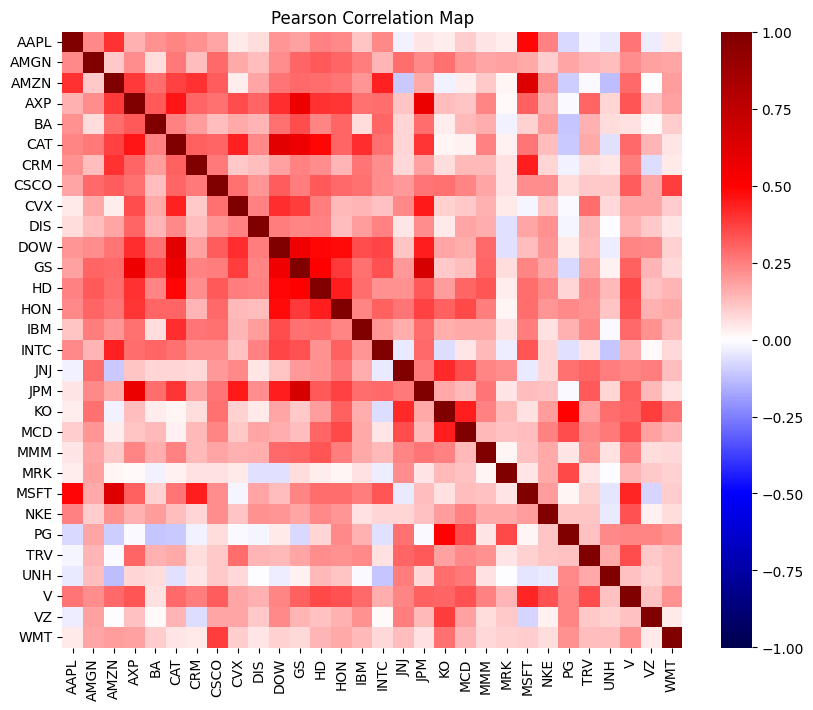

In [13]:
# Pearson Correlation:
# - parametric, assumes linearity and homoscedasticity
# - suitable for continuous variables
# - sensitive to outliers

corr_matrix_pearson = pd.DataFrame(log_returns.corr(method='pearson'))

# print(corr_matrix.to_numpy().min())

fig_pearson = plt.figure(figsize=(10,8))  # Set aspect ratio

# Could also define ax, if needed for any formatting:
#   ax = fig.add_subplot()
# or define both fig and ax as below:
#   fig, ax = plt.subplots(figsize=(10,8))

# vmin = -0.2
vmin = -1
vmax = 1
eps = 0.001
cmap = plt.cm.seismic
shifted = False
cmap_offset = 0.2

corr_plot_pearson = plot_correlations(corr_matrix_pearson, vmin, vmax, eps, cmap, shifted, cmap_offset)
plt.title('Pearson Correlation Map')

Text(0.5, 1.0, 'Kendall Correlation Map')

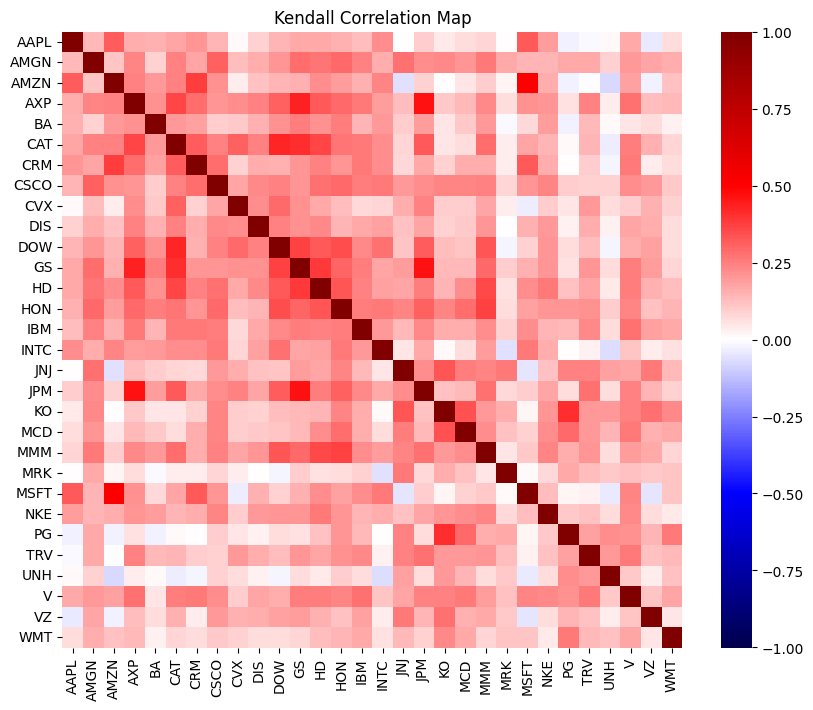

In [14]:
# Kendall Tau Correlation:
# - a non-parametric measure of association between two variables
# - assesses the strength and direction of monotonic (nonlinear) relationships
# - robust against outliers and non-normality
# - preferred when there are small samples or many rank ties

corr_matrix_kendall = pd.DataFrame(log_returns.corr(method='kendall'))

fig_kendall = plt.figure(figsize=(10,8))  # Set aspect ratio

# vmin = -0.2
vmin = -1
vmax = 1
eps = 0.001
cmap = plt.cm.seismic
shifted = False
cmap_offset = 0.2

corr_plot_kendall = plot_correlations(corr_matrix_kendall, vmin, vmax, eps, cmap, shifted, cmap_offset)
plt.title('Kendall Correlation Map')

Text(0.5, 1.0, 'Spearman Correlation Map')

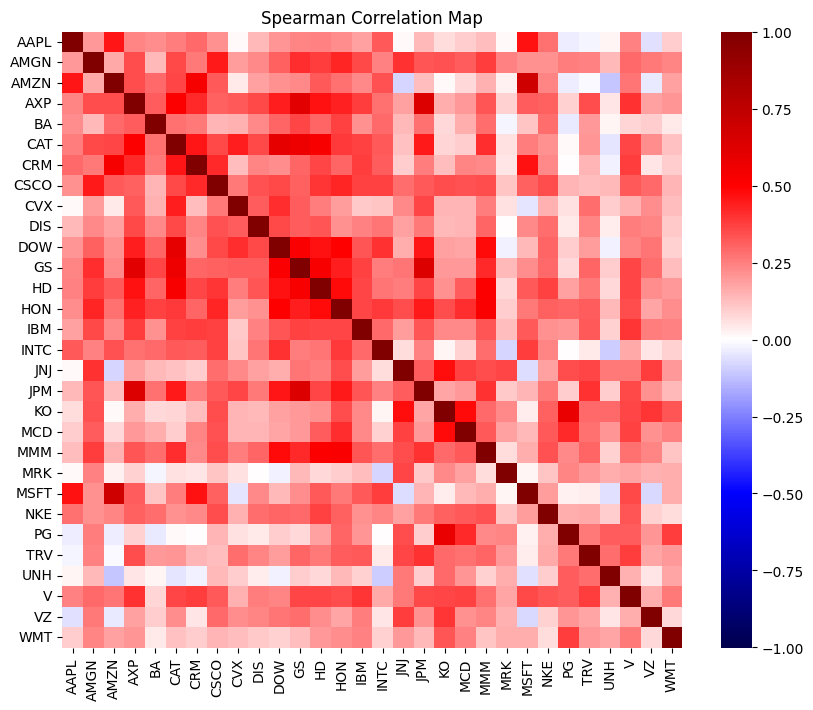

In [15]:
# Spearman Rank Correlation:
# - non-parametric, measures monotonic relationships using ranked data
# - preferred for weak correlations in small data sets
# - less sensitive than Pearson to outliers

corr_matrix_spearman = pd.DataFrame(log_returns.corr(method='spearman'))

fig_spearman = plt.figure(figsize=(10,8))  # Set aspect ratio

# vmin = -0.2
vmin = -1
vmax = 1
eps = 0.001
cmap = plt.cm.seismic
shifted = False
cmap_offset = 0.2

corr_plot_spearman = plot_correlations(corr_matrix_spearman, vmin, vmax, eps, cmap, shifted, cmap_offset)
plt.title('Spearman Correlation Map')

8. Adjusted Metrics Based on Rian Dolphin's Paper

>>a. Adjusted Covariance

In [13]:
def calculate_adjusted_covariance(
    df,
    ddof: int = 0
):
    """
    Calculates adjusted covariance matrix for an input dataframe df of returns
    ddof:       delta degrees of freedom
    ddof == 0:  use n in the divisor (population size)
    ddof > 0:   use (n - ddof) in the divisor (sample size)
    """

    n = len(df)
    k =  n - ddof
    
    tickers = df.columns
    cov_adj = pd.DataFrame(columns=tickers, index=tickers)

    for i, tk in enumerate(tickers):
        tk_series = df[tk]
        cov_adj.loc[tk, tk] = tk_series @ tk_series

        for tk2 in tickers[i + 1:]:
            tk2_series = df[tk2]
            cov_tk_tk2 = tk_series @ tk2_series
            cov_adj.loc[tk, tk2] = cov_tk_tk2
            cov_adj.loc[tk2, tk] = cov_tk_tk2

    cov_adj = cov_adj.astype(float) / k

    return cov_adj


In [14]:
cov_matrix_adj = pd.DataFrame(calculate_adjusted_covariance(log_returns))
# print(cov_matrix_adj.dtypes)

>>b. Adjusted Correlation

In [15]:
def calculate_adjusted_correlation(df):
    """
    Calculates adjusted correlation matrix for an input dataframe df of returns
    using Rian Dolphin's formula (Eq. 5)
    """

    tickers = df.columns
    corr_adj = pd.DataFrame(columns=tickers, index=tickers)

    tk_st_dev = {}
    for tk in tickers:
        tk_series = df[tk]
        tk_st_dev.update({tk: np.sqrt(tk_series @ tk_series)})

    for i, tk in enumerate(tickers):
        tk_series = df[tk]
        corr_adj.loc[tk, tk] = 1

        for tk2 in tickers[i + 1:]:
            tk2_series = df[tk2]
            corr_tk_tk2 = tk_series @ tk2_series / (tk_st_dev[tk] * tk_st_dev[tk2])
            corr_adj.loc[tk, tk2] = corr_tk_tk2
            corr_adj.loc[tk2, tk] = corr_tk_tk2

    corr_adj = corr_adj.astype(float)

    return corr_adj


Text(0.5, 1.0, 'Adjusted Correlation Map')

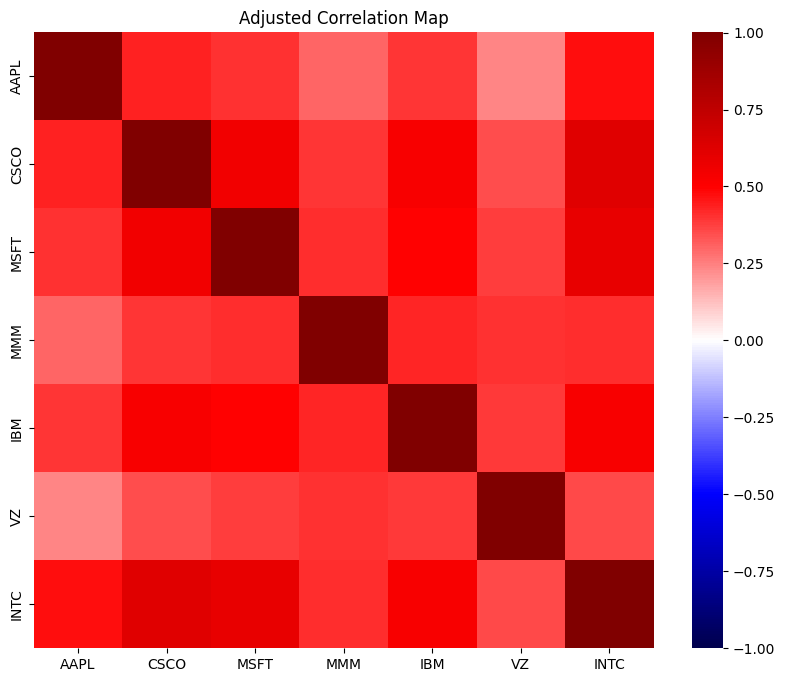

In [16]:
corr_matrix_adj = pd.DataFrame(calculate_adjusted_correlation(log_returns))

fig_corr_adj = plt.figure(figsize=(10,8))  # Set aspect ratio

# vmin = -0.2
vmin = -1
vmax = 1
eps = 0.001
cmap = plt.cm.seismic
shifted = False

corr_adj_plot = plot_correlations(corr_matrix_adj, vmin, vmax, eps, cmap, shifted)
plt.title('Adjusted Correlation Map')

>>c. Annual Returns Distance

In [17]:
def calculate_returns_distance(df, normalize=False):
    """
    Calculates Euclidean distance between annual returns for all pairs of assets in df.
    The formula is similar to Eq. 6 in Rian Dolphin's paper, except the returns are daily.
    df: dataframe of daily returns for the historical period (rows and tickers (columns)
    normalize: scale all distances to be between 0 and 1
    """
    
    tickers = df.columns
    n = len(df)
    ret_dist = pd.DataFrame(columns=tickers, index=tickers)
    
    for i, tk in enumerate(tickers):

        returns_tk = df[tk]
        ann_return_tk = np.prod(1 + returns_tk) ** (252 / n)
        ret_dist.loc[tk, tk] = 0

        for tk2 in tickers[i + 1:]:
            returns_tk2 = df[tk2]
            ann_return_tk2 = np.prod(1 + returns_tk2) ** (252 / n)
            dist_tk_tk2 = np.abs(ann_return_tk - ann_return_tk2)
            ret_dist.loc[tk, tk2] = dist_tk_tk2
            ret_dist.loc[tk2, tk] = dist_tk_tk2

    max_distance = np.max(ret_dist) if normalize else 1

    ret_dist = ret_dist.astype(float) / max_distance

    return ret_dist


def upper_limit(x):
    """
    Returns the upper/lower limit for an axis where x is the maximum/minimum value.
    units: increments of values at axis ticks, will be scaled to correspond with the
        order of magntitude of x
    intervals: how many intervals of units between 0 and upper limit do we want to have
    """

    if x == 0:
        return 0
    
    else:
        units = np.array([0.1, 0.2, 0.25, 0.5])
        intervals = np.array([4, 5, 6, 7, 8])

        order = 10 ** round(math.log10(abs(x)))
        units_scaled = order * units
        candidates = np.outer(intervals, units_scaled)
        winner = np.min(candidates[candidates - abs(x) >= 0])

        return np.sign(x) * winner

0.20264322375159693 0.25


Text(0.5, 1.0, 'Returns Distance Map')

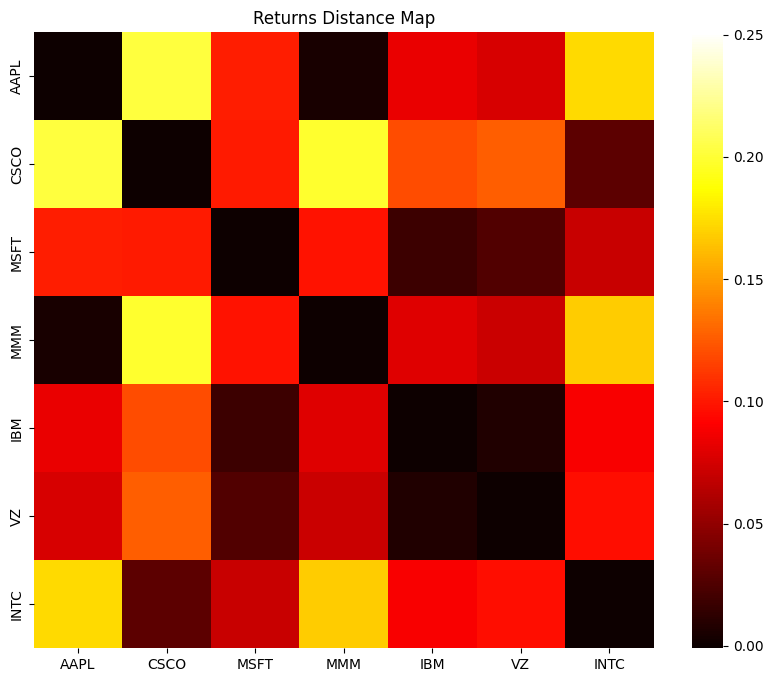

In [18]:
ret_dist_matrix = pd.DataFrame(calculate_returns_distance(log_returns, normalize=False))

ret_dist_max = np.max(ret_dist_matrix)

fig_ret_dist = plt.figure(figsize=(10,8))  # Set aspect ratio

vmin = 0
vmax = upper_limit(ret_dist_max)
print(ret_dist_max, vmax)
eps = 0.001
cmap = plt.cm.hot
shifted = False

ret_dist_plot = plot_correlations(ret_dist_matrix, vmin, vmax, eps, cmap, shifted)
plt.title('Returns Distance Map')

Text(0.5, 1.0, 'Returns Distance Map - Normalized')

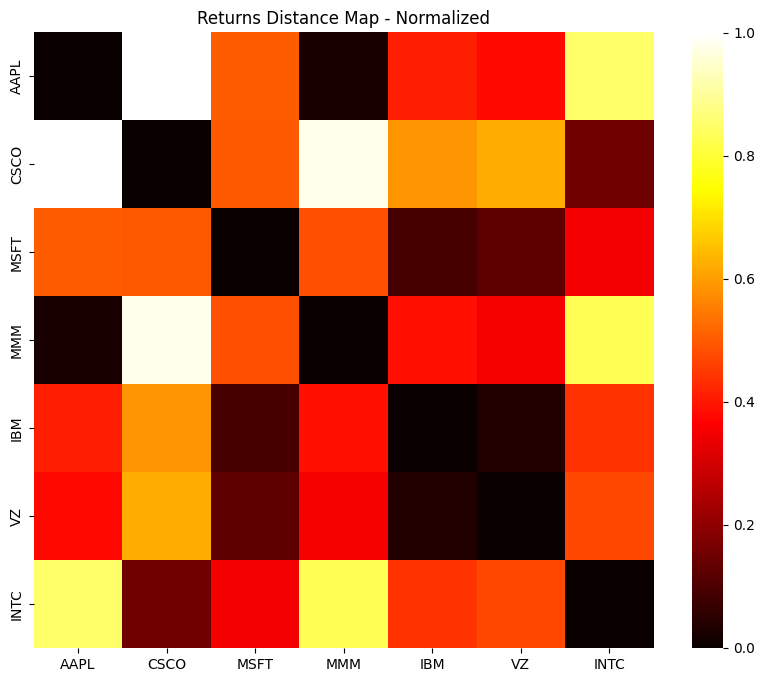

In [19]:
ret_dist_norm_matrix = pd.DataFrame(calculate_returns_distance(log_returns, normalize=True))

fig_ret_norm_dist = plt.figure(figsize=(10,8))  # Set aspect ratio

vmin = 0
vmax = 1
eps = 0.001
cmap = plt.cm.hot
shifted = False

ret_dist_norm_plot = plot_correlations(ret_dist_norm_matrix, vmin, vmax, eps, cmap, shifted)
plt.title('Returns Distance Map - Normalized')

9. Download Risk Free Rates

>> Should offer the user the choices of:
>>>- risk-free instrument (note that the rate must be annualised);
>>>- mean of historical period, initial value of historical period;
>>>- custom date or as-of-today;
>>>- lower of the two means or lower of the two daily values;
>>>- custom value.

The annual risk-free rate from the beginning of the historical period (start of investment) was used e.g. by NEDL in https://www.youtube.com/watch?v=zvChPqsKZjc

In [16]:
# NOTE: We assume that the risk-free rate is constant here but in reality it is a historical variable.
# This means that, in the calculation of Sharpe/Sortino ratio from historical returns, we should 
# use the mean of portfolio log returns minus the mean risk-free rate.

# The historical risk-free returns could be constructed in three possible ways:
#   1) based on 13-week (3-month) US Treasury Bill daily rates throughout the historical period; or
#   2) based on 10-year US Treasury Note daily rates throughout the historical period; or
#   3) based on the lower of the above two at each day throughout the historical period.
# The last option may not make too much sense, though, considering it would potentially require 
# daily adjustments to sell one type of instrument and buy the other.
#
# NOTE: The 10-yr US Treasury Note is lately offering lower rates than the 13-wk US Treasury Bill
# because of the yield curve inversion. However, it hasn't always been the case, so we should
# consider both candidates and choose the one that offers lower mean rate of the historical period.

df_risk_free_rate = pd.DataFrame()
dict_mean_risk_free_rate = {}
for tk, tk_desc in  risk_free_treasury_tickers.items():
    df_risk_free_rate[tk_desc] = yf.download(tk, start=start_date, end=end_date)['Adj Close']
    dict_mean_risk_free_rate.update({tk_desc: np.mean(df_risk_free_rate[tk_desc])})

# Get the mean risk-free rate over the historical period
risk_free_rate = 100
risk_free_instrument = df_risk_free_rate.columns[0]
for tk_desc, rate in dict_mean_risk_free_rate.items():
    if rate < risk_free_rate:
        risk_free_rate = rate
        risk_free_instrument = tk_desc

# Get the last element as the current risk-free rate
end_risk_free_rate = df_risk_free_rate[tk_desc].iloc[-1]

# Take the risk free rate as the lower of the above two
print(f'Risk-Free Rate Instrument:\t{risk_free_instrument}\nMean of Period:\t\t\t{risk_free_rate:.6f}\nAt End Date:\t\t\t{end_risk_free_rate:.6f}')

risk_free_rate = risk_free_rate / 100
end_risk_free_rate = end_risk_free_rate / 100

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Risk-Free Rate Instrument:	10-Year US Treasury Note
Mean of Period:			4.274925
At End Date:			4.593000


NOTE: Introduce the utility function U = mean return - theta * variance / 2 for a normal distribution, where theta is the investor-specific risk aversion factor. For other distributions the formula for U includes skewness and kurtosis. Investors tend to prefer positive skewness and lower kurtosis (leaner tails).

>>The portfolio weights could be optimised to maximise the utility function, see e.g. https://www.youtube.com/watch?v=skmYLg7vk3g

>>The user could be offered a selection of theta. A conservative value of theta is typically 5, more risky at around 3.5, and a really adventurous one at around 2 or less.

10. Define Portfolio Performance Metrics

>> a. Standard Deviation

In [21]:
def standard_deviation_tk(returns_tk):
    # returns_tk = log_returns[tk]
    variance = returns_tk.var(ddof=0) * 252
    return np.sqrt(variance)

def standard_deviation_portfolio(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

>> b. Expected Return

>> NOTE: Rename to average annual growth rate (AAGR) or average annual return (AAR)

In [22]:
# Assume: Expected returns are based on annualized historical returns
# NOTE: Correct below to rename the functions as average annual growth rate (AAGR) or average annual return (AAR)

def expected_return_tk(returns_tk):
    # returns_tk = log_returns[tk]
    return np.sum(returns_tk.mean()) * 252

def expected_return_portfolio(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252


>> c. Sharpe Ratio and Sortino Ratio

>> NOTE: Correct below, to offer a choice of CAGR (default) or AAGR as the expected return.

In [23]:
# Sharpe Ratio measures portfolio's excess return relative to its total risk,
# expressed through the portfolio's standard deviation of returns.
# In general, excess return is understood as the difference between the portfolio
# return and a target return. The latter can be the risk-free rate, benchmark return,
# or another arbitrarily specified rate of return.
#
# Total risk = systematic risk + unsystematic risk
#
# Systematic risk (a.k.a. market risk or undiversifiable risk) is inherent to the market
# and cannot by diversified away.
#
# Unsystematic risk (a.k.a. company-specific, diversifiable, or specific risk)
# is the type of risk that can be eliminated by portfolio diversification.
#
# The function sharpe_ratio(), as defined below, can also be used to calculate the Sortino 
# Ratio for a portfolio by using cov_matrix_downturns. --- NOTE: Not sure about this...
# The standard deviation in the Sortino Ratio is based on downturn (negative) returns only.

def sharpe_ratio_tk(returns_tk, risk_free_rate):
    # returns_tk = log_returns[tk]
    excess_return = expected_return_tk(returns_tk) - risk_free_rate
    risk_measure = standard_deviation_tk(returns_tk)
    return excess_return / risk_measure

def sharpe_ratio_portfolio(weights, log_returns, cov_matrix, risk_free_rate):
    excess_return = expected_return_portfolio(weights, log_returns) - risk_free_rate
    risk_measure = standard_deviation_portfolio(weights, cov_matrix)
    return excess_return / risk_measure

# Function to minimize using the scipy library (could also be an inverse of Sharpe ratio)
def neg_sharpe_ratio_portfolio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio_portfolio(weights, log_returns, cov_matrix, risk_free_rate)

# Sortino ratio
# NOTE: The zeros in log_returns_downturns are excluded from the calculation of standard
# deviation of downturns.
def sortino_ratio_tk(returns_tk, returns_downturns_tk, risk_free_rate):
    returns_down_tk = returns_downturns_tk[returns_downturns_tk < 0]
    excess_return = expected_return_tk(returns_tk) - risk_free_rate
    risk_measure = standard_deviation_tk(returns_down_tk)
    return excess_return / risk_measure

>>d. Probabilistic Sharpe Ratio

In [24]:
# https://quantdare.com/probabilistic-sharpe-ratio/

def prob_sharpe_ratio_tk(sharpe_ratio_tk, sharpe_ratio_threshold, n, skew_tk, kurt_tk):
    # sharpe_ratio_threshold: minimum acceptable Sharpe Ratio, e.g. benchmark's
    # NOTE kurt_tk is Pearson's kurtosis for ticker tk, as opposed to Fisher's excess kurtosis
    numerator = (sharpe_ratio_tk - sharpe_ratio_threshold) * np.sqrt(n - 1)
    denominator = np.sqrt(1 - skew_tk * sharpe_ratio_tk + 0.25 * (kurt_tk - 1) * sharpe_ratio_tk ** 2)
    return numerator / denominator
    

>>e. Treynor Ratio

In [25]:
# Similar to Sharpe Ratio, except it measures portfolio's excess return relative to its systematic risk,
# as expressed through portfolio's beta.
#
# This link may help explain when to use each of the two ratios
# https://fastercapital.com/content/Sharpe-ratio--Sharpe-Ratio-vs--Treynor-Ratio--Unraveling-the-Differences.html
# 
# The accuracy of the Treynor ratio is highly dependent on the use of appropriate benchmarks to measure beta.

def beta_portfolio(weights, df_betas):
    return (weights @ df_betas).values[0]

# Treynor ratio equals effective return divided by assets's beta
def treynor_ratio_tk (returns_tk, beta_tk, risk_free_rate):
    # returns_tk = log_returns[tk]
    # beta_tk = betas[tk] (dictionary value)
    excess_return = expected_return_tk(returns_tk) - risk_free_rate
    return excess_return / beta_tk

def treynor_ratio_portfolio (weights, log_returns, df_betas, risk_free_rate):
    excess_return = expected_return_portfolio(weights, log_returns) - risk_free_rate
    beta = beta_portfolio(weights, df_betas)  # slope of log_returns vs. market log_returns
    return excess_return / beta

def neg_treynor_ratio_portfolio(weights, log_returns, df_betas, risk_free_rate):
    return -treynor_ratio_portfolio(weights, log_returns, df_betas, risk_free_rate)


>>f. Jensen's Alpha

In [26]:
def jensens_alpha_tk(returns_tk, returns_market, beta_tk, risk_free_rate):
    # returns_tk = log_returns[tk]
    # returns_market = log_returns_market[tk_market]
    # beta_tk = betas[tk] (dictionary value)
    excess_return = expected_return_tk(returns_tk) - risk_free_rate
    excess_return_market = expected_return_tk(returns_market) - risk_free_rate
    return excess_return + beta_tk * excess_return_market
    
def jensens_alpha_portfolio(weights, log_returns, log_returns_market, df_betas, risk_free_rate):
    excess_return = expected_return_portfolio(weights, log_returns) - risk_free_rate
    excess_return_market = log_returns_market.mean() * 252 - risk_free_rate
    beta = beta_portfolio(weights, df_betas)
    return (excess_return + beta * excess_return_market).values[0]

def neg_jensens_alpha_portfolio(weights, log_returns, log_returns_market, df_betas, risk_free_rate):
    return -jensens_alpha_portfolio(weights, log_returns, log_returns_market, df_betas, risk_free_rate)


In [27]:
cols_ratios = [
    'Sharpe Ratio',
    'Prob Sharpe Ratio',
    'Sortino Ratio',
    'Treynor Ratio',
    'Jensen`s Alpha'
]
df_ratios = pd.DataFrame(columns=cols_ratios, index=tickers)

n_returns = len(log_returns)
returns_market = log_returns_market[tk_market]

# Threshold Sharpe Ratio for PSR calculation will be based on user's input, defaulting to benchmark's SR
sharpe_ratio_threshold = sharpe_ratio_tk(returns_market, risk_free_rate)

for tk in tickers:
    returns_tk = log_returns[tk]
    beta_tk = betas[tk]
    returns_down_tk = log_returns_downturns.loc[log_returns_downturns[tk] < 0, tk]  # sanity check, zeros are excluded in the function
    skew_tk = log_returns_stats.loc['Skewness', tk]
    kurt_tk = log_returns_stats.loc['Excess Kurtosis', tk] + 3  # PSR formula uses Pearson's kurtosis
    sharpe_ratio = sharpe_ratio_tk(returns_tk, risk_free_rate)
    df_ratios.loc[tk, 'Sharpe Ratio'] = sharpe_ratio
    df_ratios.loc[tk, 'Prob Sharpe Ratio'] = prob_sharpe_ratio_tk(sharpe_ratio, sharpe_ratio_threshold, n_returns, skew_tk, kurt_tk)
    df_ratios.loc[tk, 'Sortino Ratio'] = sortino_ratio_tk(returns_tk, returns_down_tk, risk_free_rate)
    df_ratios.loc[tk, 'Treynor Ratio'] = treynor_ratio_tk(returns_tk, beta_tk, risk_free_rate)
    df_ratios.loc[tk, 'Jensen`s Alpha'] = jensens_alpha_tk(returns_tk, returns_market, beta_tk, risk_free_rate)
    
print(f'Benchmark: {tk_market}')
print(df_ratios)

Benchmark: ^GSPC
     Sharpe Ratio Prob Sharpe Ratio Sortino Ratio Treynor Ratio Jensen`s Alpha
AAPL     0.423984          8.312085       0.48445      0.166666       0.197206
CSCO    -0.134413        -11.815268     -0.173631     -0.040914      -0.040215
MSFT     0.068079          0.952971      0.089709      0.020062       0.032246
MMM      0.406262          20.04761      0.553149      0.114712       0.101331
IBM      0.097946          2.850716      0.129413      0.029465       0.034764
VZ       0.118142          4.170882      0.163994      0.039857       0.037225
INTC    -0.073567         -8.349761     -0.094635     -0.021915      -0.014625


>>g. Information Ratio

In [28]:
x = np.log(df_adj_close / df_adj_close.shift(1))
log_returns = pd.DataFrame(x, columns=tickers, index=df_adj_close.index).dropna()
# The above lines are repeated in this cell for convenience

# NOTE: Annual Return is also referred to as Compound Annual Growth Rate (CAGR)

def annual_return(returns_tk, n):
    # returns_tk = log_returns[tk]
    # n = len(returns_tk)
    return np.prod(1 + returns_tk) ** (252 / n) - 1

def tracking_error(returns_tk, returns_market, ddof=0):
    # returns_tk = log_returns[tk]
    # returns_market = log_returns_market[tk_market]
    # ddof is delta degrees of freedom, = 0 for a population, = 1 for a sample
    return np.sqrt((returns_tk - returns_market).var(ddof) * 252)

def information_ratio(returns_tk, returns_market, n, ddof=0):
    # returns_tk = log_returns[tk]
    # returns_market = log_returns_market[tk_market]
    # ddof is delta degrees of freedom, = 0 for a population, = 1 for a sample)
    annual_return_tk = annual_return(returns_tk, n)
    tracking_error_tk = tracking_error(returns_tk, returns_market, ddof=0)
    return annual_return_tk / tracking_error_tk if tracking_error_tk != 0 else 0


cols_information_ratio = [
    'Annual Return',  # this is the compound annual growth rate (CAGR)
    'Tracking Error',
    'Information Ratio',
    'Expected Return'  # this is the average annual growth rate (AAGR)
]
df_information_ratio = pd.DataFrame(columns=cols_information_ratio, index=tickers)

n_returns = len(log_returns)
returns_market = log_returns_market[tk_market]

for tk in tickers:
    
    returns_tk = log_returns[tk]
    df_information_ratio.loc[tk, 'Annual Return'] = annual_return(returns_tk, n_returns)
    df_information_ratio.loc[tk, 'Tracking Error'] = tracking_error(returns_tk, returns_market, ddof=0)
    df_information_ratio.loc[tk, 'Information Ratio'] = information_ratio(returns_tk, returns_market, n_returns, ddof=0)
    df_information_ratio.loc[tk, 'Expected Return'] = expected_return_tk(returns_tk)

print(f'Benchmark: {tk_market}')
print(df_information_ratio)


Benchmark: ^GSPC
     Annual Return Tracking Error Information Ratio Expected Return
AAPL      0.090071       0.379629          0.237259        0.201177
CSCO     -0.112573       0.313456         -0.359134       -0.038423
MSFT     -0.011701       0.232052         -0.050424        0.036818
MMM       0.085824       0.168264          0.510057        0.108485
IBM       0.006923       0.199808          0.034649        0.041279
VZ        0.014071       0.209132          0.067283        0.045111
INTC     -0.082235       0.291338         -0.282268       -0.012387


>>h. Omega Ratio

In [29]:
# Assume target return is market return
# Omega = [sum(Rp - Rm) where Rp > Rm] / [sum(Rm - Rp) where Rp < Rm]
# This metric is effectively assessing the likelihood of profiting versus losing.

def omega_ratio_tk(returns_tk, returns_market):
    # returns_tk = log_returns[tk]
    # returns_market = log_returns_market[tk_market]
    excess_return = returns_tk - returns_market
    profit = np.sum(np.where(excess_return > 0, excess_return, 0))
    loss = np.sum(np.where(excess_return < 0, -excess_return, 0))
    return profit / loss if loss != 0 else 1

df_omega = pd.DataFrame(columns=['Omega Ratio'], index=tickers)

returns_market = log_returns_market[tk_market]

for tk in tickers:
    returns_tk = log_returns[tk]
    df_omega.loc[tk, 'Omega Ratio'] = omega_ratio_tk(returns_tk, returns_market)

print(df_omega)

     Omega Ratio
AAPL    1.100331
CSCO    0.958032
MSFT    1.009229
MMM     1.100126
IBM     1.015218
VZ       1.01675
INTC     0.97449


>>i. Up and Down Market Capture Ratios

In [30]:
# Up Market Capture Ratio
# up_capture = sum(Rp) / sum(Rm) where Rm > 0
# Down Market Capture Ratio
# down_capture = sum(Rp) / sum(Rm) where Rm < 0

def up_capture_ratio(returns_tk, returns_market):
    up_tk_return = np.sum(np.where(returns_market > 0, returns_tk, 0))
    up_market_return = np.sum(np.where(returns_market > 0, returns_market, 0))
    return up_tk_return / up_market_return

def down_capture_ratio(returns_tk, returns_market):
    down_tk_return = np.sum(np.where(returns_market < 0, returns_tk, 0))
    down_market_return = np.sum(np.where(returns_market < 0, returns_market, 0))
    return down_tk_return / down_market_return

cols_capture_ratio = ['Up Capture Ratio', 'Down Capture Ratio']
df_capture_ratios = pd.DataFrame(columns=cols_capture_ratio, index=tickers)

returns_market = log_returns_market[tk_market]

for tk in tickers:
    returns_tk = log_returns[tk]
    df_capture_ratios.loc[tk, 'Up Capture Ratio'] = up_capture_ratio(returns_tk, returns_market)
    df_capture_ratios.loc[tk, 'Down Capture Ratio'] = down_capture_ratio(returns_tk, returns_market)

print(df_capture_ratios)

     Up Capture Ratio Down Capture Ratio
AAPL         1.259205           1.096521
CSCO          1.30863           1.380771
MSFT         1.052737           1.044044
MMM          0.863506           0.779593
IBM          0.886069           0.868331
VZ           0.710215           0.684392
INTC         1.328078           1.373164


>>j. Amihud Illiquidity Measure

In [31]:
# Amihud Liquidity Measure
# amihud_measure = 1 / mean(Rp / DVol) over the given period,
# where Rp is portfolio return and DVol is Dollar Volume (Volume x Price).
#
# For most major tickers, the Amihud Liquidity Measure will be a huge number,
# meaning that these assets are very liquid on the market. However, the measure
# might still prove useful in assessing the liquidity of less-known assets.

In [32]:
# Calculate Amihud Liquidity Measure in billions, the greater the more liquidity

def amihud_tk(returns_tk, dollar_volume_tk):
    return 1e-9 / np.mean(np.abs(returns_tk) / dollar_volume_tk)

col_amihud = 'Amihud Liquidity (Bln)'
df_amihud = pd.DataFrame(columns=[col_amihud], index=tickers)

for tk in tickers:
    returns_tk = log_returns[tk]
    dollar_volume_tk = df_dollar_volume[tk]
    df_amihud.loc[tk, col_amihud] = amihud_tk(returns_tk, dollar_volume_tk)

print(df_amihud)


     Amihud Liquidity (Bln)
AAPL              15.506295
CSCO               45.63878
MSFT             102.474839
MMM               16.525008
IBM               39.807544
VZ                13.475907
INTC              47.748934


In [33]:
n = len(tickers)
constraints = {
    'type': 'eq',
    'fun': lambda weights: np.sum(weights) - 1
}
# bounds = [(0, 0.4) for _ in range(n)]
bounds = [(0, 0.9) for _ in range(n)]
initial_weights = np.array([1 / n] * n)

In [34]:
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

>>11. Optimal Sharpe Ratio

In [35]:
# method = 'SLSQP'
# methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov']
# methods = ['Nelder-Mead', 'Powell', 'CG', 'L-BFGS-B', 'SLSQP', 'trust-constr']
# methods = ['trust-constr', 'SLSQP']
methods = ['SLSQP']
for method in methods:
    optimized_results_sharpe = minimize(
        neg_sharpe_ratio_portfolio,
        initial_weights,
        args=(log_returns, cov_matrix, risk_free_rate),
        method=method,
        constraints=constraints,
        bounds=bounds
    )
    optimal_weights_sharpe = optimized_results_sharpe.x
    print(method)
    for tk, wt in zip(tickers, optimal_weights_sharpe):
        total_log_return = log_returns[tk].sum()
        # if total_log_return > 0:
        if wt > 1e-6:
            # print(f'\t{tk}:\t{total_log_return:.6f}\t{wt:.6f}')
            print(f'\t{tk}:\t{wt:.6f}')
    
    optimal_sharpe_return = expected_return_portfolio(optimal_weights_sharpe, log_returns)
    optimal_sharpe_risk = standard_deviation_portfolio(optimal_weights_sharpe, cov_matrix)
    optimal_sharpe_ratio = sharpe_ratio_portfolio(optimal_weights_sharpe, log_returns, cov_matrix, risk_free_rate)
    
    print(f'\tRisk Free Rate:\t\t{risk_free_rate:.6f}')
    print(f'\tOptimal Sharpe Return:\t{optimal_sharpe_return:.6f}')
    print(f'\tOptimal Sharpe Risk:\t{optimal_sharpe_risk:.6f}')
    print(f'\tOptimal Sharpe Ratio:\t{optimal_sharpe_ratio:.6f}')
    

SLSQP
	AAPL:	0.361740
	MMM:	0.638260
	Risk Free Rate:		0.015634
	Optimal Sharpe Return:	0.142015
	Optimal Sharpe Risk:	0.245145
	Optimal Sharpe Ratio:	0.515539


>>12. Optimal Sortino Ratio

In [36]:
for method in methods:
    optimized_results_sortino = minimize(
        neg_sharpe_ratio_portfolio,
        initial_weights,
        args = (log_returns, cov_matrix_downturns, risk_free_rate),
        method = method,
        constraints = constraints,
        bounds = bounds
    )
    optimal_weights_sortino = optimized_results_sortino.x
    print(method)
    for tk, wt in zip(tickers, optimal_weights_sortino):
        total_log_return = log_returns[tk].sum()
        # if total_log_return > 0:
        if wt > 1e-6:
            # print(f'\t{tk}:\t{total_log_return:.6f}\t{wt:.6f}')
            print(f'\t{tk}:\t{wt:.6f}')
    
    optimal_sortino_return = expected_return_portfolio(optimal_weights_sortino, log_returns)
    # NOTE: Not sure about portfolio Sortino Ratio, as the covariance matrix includes zero returns
    optimal_sortino_risk = standard_deviation_portfolio(optimal_weights_sortino, cov_matrix_downturns)
    optimal_sortino_ratio = sharpe_ratio_portfolio(optimal_weights_sortino, log_returns, cov_matrix_downturns, risk_free_rate)
    
    print(f'\tRisk Free Rate:\t\t{risk_free_rate:.6f}')
    print(f'\tOptimal Sortino Return:\t{optimal_sortino_return:.6f}')
    print(f'\tOptimal Sortino Risk:\t{optimal_sortino_risk:.6f}')
    print(f'\tOptimal Sortino Ratio:\t{optimal_sortino_ratio:.6f}')

SLSQP
	AAPL:	0.294246
	MMM:	0.705754
	Risk Free Rate:		0.015634
	Optimal Sortino Return:	0.135759
	Optimal Sortino Risk:	0.147390
	Optimal Sortino Ratio:	0.815021


>>13. Optimal Treynor Ratio

In [37]:
for method in methods:
    optimized_results_treynor = minimize(
        neg_treynor_ratio_portfolio,
        initial_weights,
        args = (log_returns, df_betas, risk_free_rate),
        method = method,
        constraints = constraints,
        bounds = bounds
    )
    optimal_weights_treynor = optimized_results_treynor.x
    print(method)
    for tk, wt in zip(tickers, optimal_weights_treynor):
        total_log_return = log_returns[tk].sum()
        # if total_log_return > 0:
        if wt > 1e-6:
            # print(f'\t{tk}:\t{total_log_return:.6f}\t{wt:.6f}')
            print(f'\t{tk}:\t{wt:.6f}')
    
    optimal_treynor_return = expected_return_portfolio(optimal_weights_treynor, log_returns)
    optimal_treynor_risk = beta_portfolio(optimal_weights_treynor, df_betas)
    optimal_treynor_ratio = treynor_ratio_portfolio(optimal_weights_treynor, log_returns, df_betas, risk_free_rate)
    
    print(f'\tRisk Free Rate:\t\t{risk_free_rate:.6f}')
    print(f'\tOptimal Treynor Return:\t{optimal_treynor_return:.6f}')
    print(f'\tOptimal Treynor Risk:\t{optimal_treynor_risk:.6f}')
    print(f'\tOptimal Treynor Ratio:\t{optimal_treynor_ratio:.6f}')

SLSQP
	AAPL:	0.900000
	MMM:	0.100000
	Risk Free Rate:		0.015634
	Optimal Treynor Return:	0.191908
	Optimal Treynor Risk:	1.082882
	Optimal Treynor Ratio:	0.162782


>>14. Optimal Jensen's Alpha

In [38]:
for method in methods:
    optimized_results_alpha = minimize(
        neg_jensens_alpha_portfolio,
        initial_weights,
        args = (log_returns, log_returns_market, df_betas, risk_free_rate),
        method = method,
        constraints = constraints,
        bounds = bounds
    )
    optimal_weights_alpha = optimized_results_alpha.x
    print(method)
    for tk, wt in zip(tickers, optimal_weights_alpha):
        total_log_return = log_returns[tk].sum()
        if wt > 1e-6:
            print(f'\t{tk}:\t{wt:.6f}')
    
    optimal_alpha_return = expected_return_portfolio(optimal_weights_alpha, log_returns)
    optimal_alpha_portfolio_beta = beta_portfolio(optimal_weights_alpha, df_betas)
    optimal_jensens_alpha = jensens_alpha_portfolio(optimal_weights_alpha, log_returns, log_returns_market, df_betas, risk_free_rate)
    
    print(f'\tRisk Free Rate:\t\t\t{risk_free_rate:.6f}')
    print(f'\tOptimal Alpha Return:\t\t{optimal_alpha_return:.6f}')
    print(f'\tOptimal Alpha Portfolio Beta:\t{optimal_alpha_portfolio_beta:.6f}')
    print(f"\tOptimal Jensen's Alpha:\t\t{optimal_jensens_alpha:.6f}")

SLSQP
	AAPL:	0.900000
	MMM:	0.100000
	Risk Free Rate:			0.015634
	Optimal Alpha Return:		0.191908
	Optimal Alpha Portfolio Beta:	1.082882
	Optimal Jensen's Alpha:		0.187619


NOTES:
>1)  Must not standardize returns if they are to be used for Sharpe ratio calculation. Standardized
>    returns will have a mean of 0, leading to a zero expected return.
>2)  Also must not standardize returns if they are to be used for the calculation of annual returns.
>3)  Covariance matrix based on standardized returns is equivalent to correlation matrix.
>4)  Covariance based on standardized daily returns need not be multiplied by 252 to be annualized.
>5)  Correlation matrix based on standardized returns is the same as the one based on regular returns.


PCA Analysis

In [39]:
import sys
# sys.exit()

# n_pca = 7
n_pca = len(tickers)
pca_range = range(n_pca)
pca_columns = ['PC_' + str(i + 1) for i in pca_range]
dict_pca_columns = dict(zip(pca_range, pca_columns))
print(dict_pca_columns)

# pca_portfolio = PCA(n_components=n_pca).fit_transform(log_returns_standardized)
# 
# svd_solver must be one of 'auto' (deflault), 'arpack', 'randomized', and 'full'.
# If svd_solver is arpack, then n_components must be less than the number of tickers
pca = PCA(n_components=n_pca, svd_solver='randomized')
pca_fit = pca.fit(log_returns_standardized)

# print(pca_fit.explained_variance_)
# NOTE: explained_variance_ is based on ddof=1, which does not matter for explained_variance_ratio_
# print(pca_fit.explained_variance_ratio_)
# print(pca_fit.feature_names_in_)

eigenvectors = pca_fit.components_
# if np.mean(eigenvectors[0]) < 0:
eigenvectors *= np.sign(np.mean(eigenvectors[0]))

print(f'Principal Components (Eigenvectors)\n{eigenvectors}')

pca_portfolio = pca_fit.transform(log_returns_standardized)
# NOTE: 
# 1) After applying transform() or fit_transform(), we cannot use explained_variance_ or
# explained_variance_ratio, that's why pca_portfolio does not have these two attributes.
# 2) explained_variance_ratio_ is the same as the sorted precentage eigenvalues

df_pca = pd.DataFrame(data=pca_portfolio, columns=pca_columns, index=log_returns_standardized.index)

# print(df_pca)

for col in pca_columns:
    print(f'Standard Deviation of {col}: {np.sqrt(df_pca[col].var(ddof=0))}')
    # print(f'Variance of {col}: {df_pca[col].var(ddof=0)}')

# print(tickers)
w, v = np.linalg.eig(corr_matrix_pearson)
# w = np.linalg.eigvals(corr_matrix_pearson)
print('NUMPY')
print('Eigenvalues:\n', w)
# NOTE: These eigenvalues correspond to variance with ddof=0, unlike explained_variance_
w_total = np.sum(w)
print('Percent Eigenvalues', 100 * w / w_total)
# NOTE: Eigenvectors are columns of v corresponding to eigenvalues w
# print(f'Eigenvectors:\n{v.T}')

"""
# The same can be achieved using scipy.linalg.eig():
print('\nSCIPY')
v1 = linalg.eigvals(corr_matrix_pearson)
print('Eigenvalues:\n', v1)
# w1_total = np.sum(w1)
# print('Percent Eigenvalues', 100 * w1 / w1_total)
w1 = linalg.eig(corr_matrix_pearson)
print('Eigenvectors:\n', w1[1])
# NOTE: linalg.eig produces both eigenvalues and eigenvectors as an array of two arrays
"""
"""
print('\nPearson Correlation Matrix:')
display(corr_matrix_pearson)
print('Covariance Matrix:')
display(cov_matrix)
"""
# ADD SCREE PLOT - Eigenvalue vs Component Number
# ADD BIPLOT(S) - e.g. Component 1 vs Component 2

{0: 'PC_1', 1: 'PC_2', 2: 'PC_3', 3: 'PC_4', 4: 'PC_5', 5: 'PC_6', 6: 'PC_7'}
Principal Components (Eigenvectors)
[[ 0.33417612  0.41308684  0.40689872  0.34187112  0.39707096  0.31199856
   0.42454058]
 [-0.47192541 -0.21923642 -0.07183774  0.46380021  0.01514775  0.67509766
  -0.2301395 ]
 [-0.77785443  0.3069129   0.34137125 -0.33135571  0.12851914 -0.11005612
   0.21397779]
 [-0.21324619  0.01454966 -0.02926991  0.72986055  0.0594993  -0.64579633
   0.0129675 ]
 [ 0.03250048  0.05735891  0.40275909  0.1498764  -0.87868953  0.0644771
   0.18634181]
 [-0.0797633   0.61979762 -0.70494637  0.05149373 -0.22226271  0.11434432
   0.21774389]
 [ 0.08753745  0.5472187   0.22960277  0.02014756 -0.0234918  -0.02242505
  -0.79919383]]
Standard Deviation of PC_1: 1.9046113034703078
Standard Deviation of PC_2: 0.9203002102815337
Standard Deviation of PC_3: 0.7855262031787121
Standard Deviation of PC_4: 0.7669221614139057
Standard Deviation of PC_5: 0.7138627365236132
Standard Deviation of PC_6: 

"\nprint('\nPearson Correlation Matrix:')\ndisplay(corr_matrix_pearson)\nprint('Covariance Matrix:')\ndisplay(cov_matrix)\n"

In [40]:
st_devs = np.array(log_returns_stats.loc['Standard Deviation', :])

# In eigenvectors, each row corresponds to one eigenvector;
# pca_weights will have the same structure, with each column corresponding to one ticker.

pca_weights = (eigenvectors.T / st_devs).T
# print('Before normalization:')
# print(pca_weights)

# Normalize row-wise to have sum the weights for each PC sum up to 1
# https://stackoverflow.com/questions/8904694/how-to-normalize-a-2-dimensional-numpy-array-in-python-less-verbose
row_sums = pca_weights.sum(axis=1, keepdims=True)
pca_weights = pca_weights / row_sums

# NOTE: The magnitude of some weights after normalization may be >> 1, but their sum will still be 1

print(row_sums.T)
print('After normalization:')
for pcw in pca_weights:
    print(pcw)

print(pca_weights.sum(axis=1))

# These weights can be inputted to any function calculating portfolio-level quantity.
# There could also be a 'PORTFOLIO' column in log_returns, initially containing 
# values corresponding to uniform weights, and later updated when the weights change.
# Or, better yet, the portfolio returns could be in a separate df/array, with each
# column corresponding to a different component/eigenvector.

[[95.38963543614224 6.351330599744916 -11.656289161428647
  -4.961714236827974 0.8866418091400785 -0.22859046903572633
  1.6419543128781413]]
After normalization:
[0.12708041863343728 0.15708856779086247 0.1547353536774196
 0.1300066717618402 0.1509980541745985 0.11864673935155856
 0.16144419461028334]
[-2.9329161150092844 -1.3625077740743714 -0.4464562782156208
 2.8824197427280738 0.0941400407157003 4.195588471546761
 -1.4302680876912577]
[3.4043975703393614 -1.3432507084170924 -1.4940629141163873
 1.4502283952614134 -0.5624834610284621 0.4816772680255746
 -0.9365061500644074]
[2.985160886578117 -0.20367574248928202 0.40973945981697496
 -10.217069648953744 -0.8329104967457073 9.040283155370497
 -0.1815276135768572]
[2.2223651875699826 3.922170718726448 27.540443870177924
 10.248465659376723 -60.08430399858608 4.408908640206433
 12.741949922528564]
[22.200730008045465 -172.5099138239841 196.20959287648674
 -14.332386618565819 61.86296824872682 -31.825756293633038
 -60.60523439707608]
[

PC_1 vs PC_2
0.37499999999999994
AAPL: x = 0.33417612044430206, y = -0.4719254106845321, dx = 0.022913850909033112, dy = -0.03235907008026902
CSCO: x = 0.41308683678422875, y = -0.21923642396396323, dx = 0.027910600033556915, dy = -0.014812914857516245
MSFT: x = 0.40689872400130317, y = -0.0718377390240933, dx = 0.029278671740924, dy = -0.0051691328958059285
MMM: x = 0.3418711212036904, y = 0.46380021368181656, dx = 0.018933973392564647, dy = 0.025686816933815113
IBM: x = 0.3970709609027752, y = 0.015147749077874598, dx = 0.02466188323467445, dy = 0.0009408192887672837
VZ: x = 0.3119985556093987, y = 0.6750976621408503, dx = 0.011765195259895772, dy = 0.02545734802865537
INTC: x = 0.4245405799200279, y = -0.2301395021897994, dx = 0.027852307367344672, dy = -0.01509847693138178
PC_3 vs PC_4
AAPL: x = -0.7778544333814769, y = -0.21324618947983257, dx = -0.07486357034929886, dy = -0.020523597247422365
CSCO: x = 0.306912896363303, y = 0.01454966001015183, dx = 0.07677609252443163, dy = 0.0

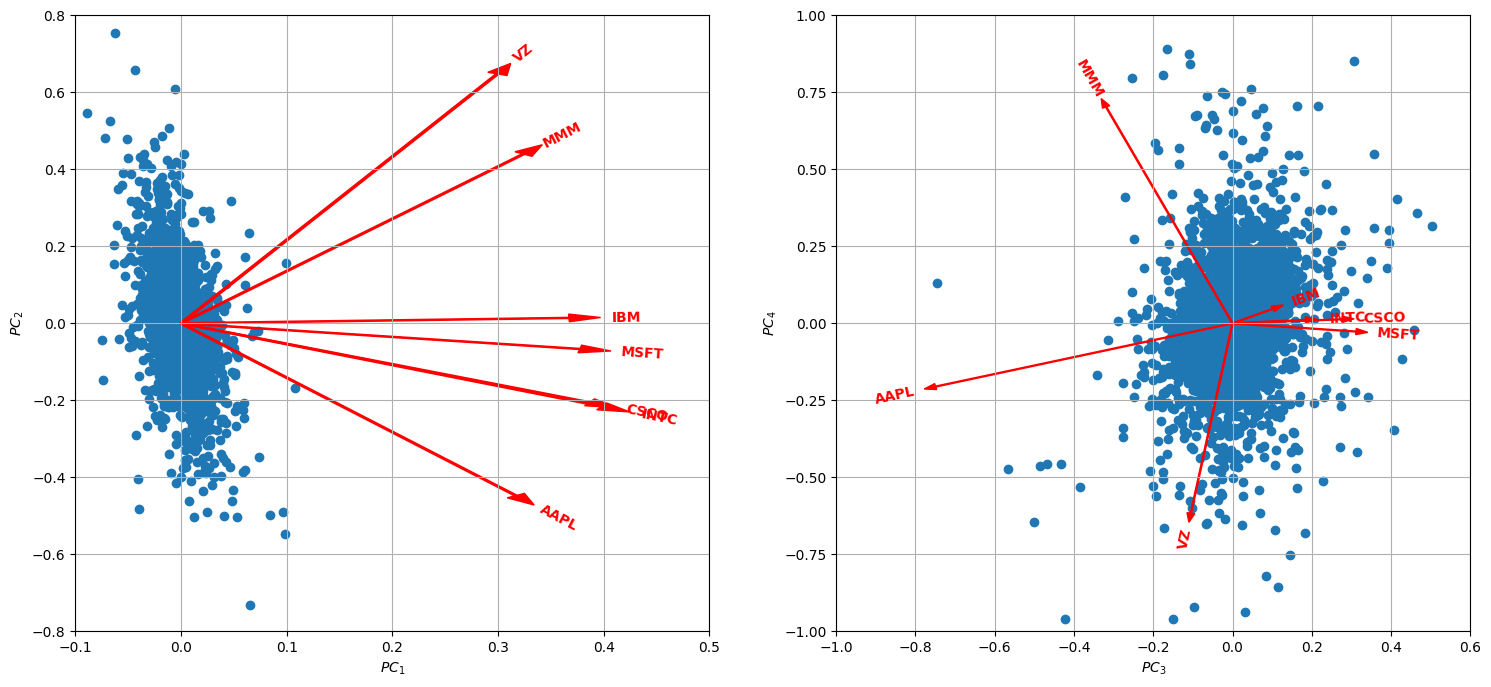

'\nfirst_return = log_returns.loc[log_returns.index[0]]\nsecond_return = log_returns.loc[log_returns.index[1]]\nfirst_component = pca_weights[0]\nsecond_component = pca_weights[1]\n\nprint(second_return, second_component)\nprint(first_return @ first_component)\nprint(second_return @ second_component)\ndisplay(log_returns @ pca_weights[0])\ndisplay(log_returns @ pca_weights[1])\n'

In [41]:
pca_returns = log_returns @ pca_weights.T  # an array
df_pca_returns = pd.DataFrame(data=pca_returns, index=df_pca.index)
df_pca_returns.rename(columns=dict_pca_columns, inplace=True)
df_pca_returns = df_pca_returns.astype(float)

# print(df_pca_returns)

print(f'PC_1 vs PC_2')
set_lim12 = True
x12_lim = [-0.1, 0.5]
y12_lim = [-0.8, 0.8]
d12 = np.sqrt((x12_lim[1] - x12_lim[0]) ** 2 + (y12_lim[1] - y12_lim[0]) ** 2)
tk_offset_coef12 = 0.006  # distance from arrow tip to centre of ticker label (as a fraction of d12)
tk_length_coef12 = 0.0075 # additional shift required to account for ticker label length 
aspect_ratio_12 = (x12_lim[1] - x12_lim[0]) / (y12_lim[1] - y12_lim[0])
print(aspect_ratio_12)
# d12 = distance as a percentage of diagonal length

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
plt.subplot(1, 2, 1).scatter(df_pca_returns['PC_1'], df_pca_returns['PC_2'])
plt.grid(axis='both')
ax1.set(xlabel=f'$PC_1$', ylabel=f'$PC_2$')
if set_lim12:
    ax1.set(xlim=x12_lim, ylim=y12_lim)

for i, tk in enumerate(tickers):
    eig_x = eigenvectors[0, i]
    eig_y = eigenvectors[1, i]
    label_angle = math.atan(aspect_ratio_12 * eig_y / eig_x)
    label_angle_deg = math.degrees(label_angle)
    
    # offset due to distance from arrow tip
    x_delta = np.sign(eig_x) * d12 * tk_offset_coef12 / np.sqrt((eig_y / eig_x) ** 2 + 1)
    # longer tickers may overlap with the arrow, so add offset due to ticker length
    x_delta += np.sign(eig_x) * len(tk) * d12 * tk_length_coef12 * math.cos(label_angle) * aspect_ratio_12
    y_delta = x_delta * eig_y / eig_x

    print(f'{tk}: x = {eig_x}, y = {eig_y}, dx = {x_delta}, dy = {y_delta}')
    
    ax1.arrow(0, 0, eig_x, eig_y, color='r', width=0.003, head_width=0.02, length_includes_head=True)
    ax1.text(eig_x + x_delta, eig_y + y_delta, tk, color='r', ha='center', va='center', fontweight='bold', rotation=label_angle_deg)
    # ax1.annotate(tk, (eigenvectors[i, 0] + h_label_shift, eigenvectors[1, 1] + v_label_shift), color='r', ha='center', va='center')


print(f'PC_3 vs PC_4')
set_lim34 = True
x34_lim = [-1.0, 0.6]
y34_lim = [-1.0, 1.0]
d34 = np.sqrt((x34_lim[1] - x34_lim[0]) ** 2 + (y34_lim[1] - y34_lim[0]) ** 2)
tk_offset_coef34 = 0.006  # distance from arrow tip to centre of ticker label (as a fraction of d34)
tk_length_coef34 = 0.0075 # additional shift required to account for ticker label length 

# d34 = distance as a percentage of diagonal length
aspect_ratio_34 = (x34_lim[1] - x34_lim[0]) / (y34_lim[1] - y34_lim[0])

plt.subplot(1, 2, 2).scatter(df_pca_returns['PC_3'], df_pca_returns['PC_4'])
plt.grid(axis='both')
ax2.set(xlabel=f'$PC_3$', ylabel=f'$PC_4$')
if set_lim34:
    ax2.set(xlim=x34_lim, ylim=y34_lim)

for i, tk in enumerate(tickers):
    eig_x = eigenvectors[2, i]
    eig_y = eigenvectors[3, i]
    label_angle = math.atan(aspect_ratio_34 * eig_y / eig_x)
    label_angle_deg = math.degrees(label_angle)
    
    # offset due to distance from arrow tip
    x_delta = np.sign(eig_x) * d34 * tk_offset_coef34 / np.sqrt((eig_y / eig_x) ** 2 + 1)
    # longer tickers may overlap with the arrow, so add offset due to ticker length
    x_delta += np.sign(eig_x) * len(tk) * d34 * tk_length_coef34 * math.cos(label_angle) * aspect_ratio_34
    y_delta = x_delta * eig_y / eig_x

    print(f'{tk}: x = {eig_x}, y = {eig_y}, dx = {x_delta}, dy = {y_delta}')

    ax2.arrow(0, 0, eig_x, eig_y, color='r', width=0.003, head_width=0.02, length_includes_head=True)
    ax2.text(eig_x + x_delta, eig_y + y_delta, tk, color='r', ha='center', va='center', fontweight='bold', rotation=label_angle_deg)

plt.show()

# ax = fig_pca.add_subplot()

"""
first_return = log_returns.loc[log_returns.index[0]]
second_return = log_returns.loc[log_returns.index[1]]
first_component = pca_weights[0]
second_component = pca_weights[1]

print(second_return, second_component)
print(first_return @ first_component)
print(second_return @ second_component)
display(log_returns @ pca_weights[0])
display(log_returns @ pca_weights[1])
"""

In [42]:
pca_cols = df_pca_returns.columns
pca_returns_stats = pd.DataFrame(columns=pca_cols, index=stats_metrics)

for tk in pca_cols:
    returns_tk = df_pca_returns[tk]
    tk_stats = stats.describe(returns_tk)
    pca_returns_stats.loc['Observations', tk] = len(returns_tk)
    pca_returns_stats.loc['Minimum', tk] = tk_stats.minmax[0]
    pca_returns_stats.loc['Maximum', tk] = tk_stats.minmax[1]
    pca_returns_stats.loc['Mean', tk] = tk_stats.mean
    pca_returns_stats.loc['Median', tk] = np.median(returns_tk)
    pca_returns_stats.loc['Standard Deviation', tk] = np.sqrt(returns_tk.var(ddof=0))
    pca_returns_stats.loc['Variance', tk] = returns_tk.var(ddof=0)
    pca_returns_stats.loc['Annual Volatility', tk] = np.sqrt(returns_tk.var(ddof=0) * 252)
    pca_returns_stats.loc['Annual Variance', tk] = returns_tk.var(ddof=0) * 252
    pca_returns_stats.loc['Skewness', tk] = tk_stats.skewness
    pca_returns_stats.loc['Excess Kurtosis', tk] = tk_stats.kurtosis
    pca_returns_stats.loc['1% 1-Day VaR', tk] = historical_var(returns_tk, p_level=1)
    pca_returns_stats.loc['1% 1-Day CVaR', tk] = historical_cvar(returns_tk, p_level=1)
    pca_returns_stats.loc['5% 1-Day VaR', tk] = historical_var(returns_tk, p_level=5)
    pca_returns_stats.loc['5% 1-Day CVaR', tk] = historical_cvar(returns_tk, p_level=5)
    pca_returns_stats.loc['Jarque-Bera p-Value', tk] = stats.jarque_bera(returns_tk).pvalue

display(pca_returns_stats)

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
Observations,4232,4232,4232,4232,4232,4232,4232
Minimum,-0.118992,-0.73097,-2.287134,-1.86312,-6.030476,-29.019319,-2.676262
Maximum,0.107544,2.433439,0.503321,0.890414,11.320741,33.621762,4.563202
Mean,0.000194,-0.000121,0.003369,-0.000434,-0.000068,0.073938,0.001525
Median,0.000653,-0.002686,0.00232,-0.00094,0.001463,0.031418,0.002021
Standard Deviation,0.015129,0.119246,0.085961,0.171833,0.8622,4.189106,0.372392
Variance,0.000229,0.01422,0.007389,0.029526,0.743389,17.548607,0.138676
Annual Volatility,0.240164,1.892972,1.364585,2.727759,13.686999,66.499992,5.911539
Annual Variance,0.057679,3.583341,1.862093,7.440669,187.333928,4422.248878,34.946292
Skewness,0.05594,2.216689,-4.508704,-0.399891,0.720094,0.093013,0.802975


In [43]:
# Some testing for 3 PCA components, including a general solution of a cubic equation
arr_corr = np.array(corr_matrix_pearson)
rho12 = arr_corr[0, 1]
rho13 = arr_corr[0, 2]
rho23 = arr_corr[1, 2]
# print(arr_corr)
print(rho12, rho13, rho23)

p = - (rho12 ** 2 + rho13 ** 2 + rho23 ** 2)
q = 2 * rho12 * rho13 * rho23
print(p, q)
# discriminant = (p / 3 ) ** 3 + (q / 2) **2
# print(discriminant)

# After Vieta's substitution, solving for w^3, where x = w - p / (3 * w):
b = -q
c = - (p / 3) ** 3
delta = b ** 2 - 4 * c

phi = math.acos(-0.5 * q / np.sqrt(abs(p) ** 3 / 27))
p0 = 2 * np.sqrt(abs(p) / 3)

x1 = p0 * math.cos(phi / 3)
x2 = - p0 * math.cos((phi + math.pi) / 3)
x3 = - p0 * math.cos((phi - math.pi) / 3)

lambda1 = 1 - x1
lambda2 = 1 - x2
lambda3 = 1 - x3
print(f'lambda1: {lambda1}')
print(f'lambda2: {lambda2}')
print(f'lambda3: {lambda3}')

0.43582238507076154 0.4007970983081925 0.5513506562459918
-0.6545670114839199 0.1926158374445823
lambda1: 0.4460645576117598
lambda2: 0.6254819917007349
lambda3: 1.9284534506875055


>>> The SLSQP method delivers a higher Sharpe Ratio than does the trust-constr method. The other methods fail on either the constraints or the bounds.

In [44]:
tk = 'TSLA'
# tk_data = yf.download(tk, start=start_date, end=end_date)
tk_data = yf.download(tk)
print(len(tk_data))

tk_info = yf.Ticker(tk).info
vol_keys = ['averageVolume', 'averageVolume10days', 'averageDailyVolume10Day']
for key in vol_keys:
    print(f'{key}: {tk_info[key]}')

# The ave_vol variable refers to a prior period of 62 business days
ave_vol = tk_info['averageVolume'] 
print(f'ave_vol: {ave_vol}')

# The ave_vol_10d variable refers to a prior period of 10 business days
# It appears to have the same value as tk_info['averageDailyVolume10Day']
ave_vol_10d = tk_info['averageVolume10days'] 
print(f'ave_vol_10d: {ave_vol_10d}')

for j in range(2):
    j10 = j + 10
    tk_data_10mean = tk_data[-j10: -j]['Volume'].mean()
    if abs(tk_data_10mean / ave_vol_10d - 1) < 1e-6:
        print(tk_data_10mean)

n = len(tk_data)
for i in range(n):
    tk_data_mean = tk_data[-i: -1]['Volume'].mean()
    if abs(tk_data_mean / ave_vol - 1) < 1e-6:
        print(f"{i}:\t{tk_data_mean}")

[*********************100%%**********************]  1 of 1 completed

3568


averageVolume: 94846976
averageVolume10days: 71882580
averageDailyVolume10Day: 71882580
ave_vol: 94846976
ave_vol_10d: 71882580
71882580.0
64:	94846976.1904762
